## Import Modules and Establish environment

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "2"
from sklearn.cluster import SpectralClustering

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import SpectralClustering
import geopandas as gpd
import networkx as nx
import matplotlib.dates as mdates

## Import Data

In [3]:
#Import Taxi Zones
current_directory = os.getcwd()
taxi_zone_path = os.path.join("Data Repo", "taxi-zone-lookup.csv")
taxi_zones = pd.read_csv(taxi_zone_path)

In [4]:
#Load NYC Taxi Zones shapefile (used in the plots we'll make below)
shp_path = os.path.join("Data Repo", "taxi_zones.shp")
zones_gdf = gpd.read_file(shp_path)

### Define Function to Import Uber Rides

In [5]:
import pandas as pd
from tqdm import tqdm

usecols = ['request_datetime', 'PULocationID', 'DOLocationID']

#set low-memory dtypes
dtypes = {
    'PULocationID': 'uint16',
    'DOLocationID': 'uint16'
}

datetime_format = "%m/%d/%Y %I:%M:%S %p"

def load_large_csv_in_chunks(file_path, chunksize=500_000):
    filtered_chunks = []

    for chunk in tqdm(pd.read_csv(file_path,
                                   usecols=usecols,
                                   dtype=dtypes,
                                   parse_dates=['request_datetime'],
                                   date_format=datetime_format,
                                   chunksize=chunksize),
                      desc="Reading & filtering chunks"):
        #filter NYC rides (IDs 1–263)
        chunk = chunk[(chunk['PULocationID'].between(1, 263)) &
                      (chunk['DOLocationID'].between(1, 263))]
        filtered_chunks.append(chunk)

    df = pd.concat(filtered_chunks, ignore_index=True)
    return df

In [6]:
mega_file = r'Data Repo/2023_High_Volume_FHV_Trip_Data.csv'
df_2023 = load_large_csv_in_chunks(mega_file)

print(df_2023.info())
print(df_2023.head())

Reading & filtering chunks: 321it [51:12,  9.57s/it]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160346947 entries, 0 to 160346946
Data columns (total 3 columns):
 #   Column            Dtype         
---  ------            -----         
 0   request_datetime  datetime64[ns]
 1   PULocationID      uint16        
 2   DOLocationID      uint16        
dtypes: datetime64[ns](1), uint16(2)
memory usage: 1.8 GB
None
     request_datetime  PULocationID  DOLocationID
0 2023-01-01 23:21:31           211           263
1 2023-01-03 15:06:54           132           263
2 2023-01-02 00:00:34           142           263
3 2023-01-02 19:07:38            74           263
4 2023-01-02 12:22:42           239           263


## EDA

In [7]:
#Historgram of rides over time
df_2023["day_of_week"] = df_2023["request_datetime"].dt.day_name()
df_2023["request_time_of_day"] = df_2023["request_datetime"].dt.hour + df_2023["request_datetime"].dt.minute / 60

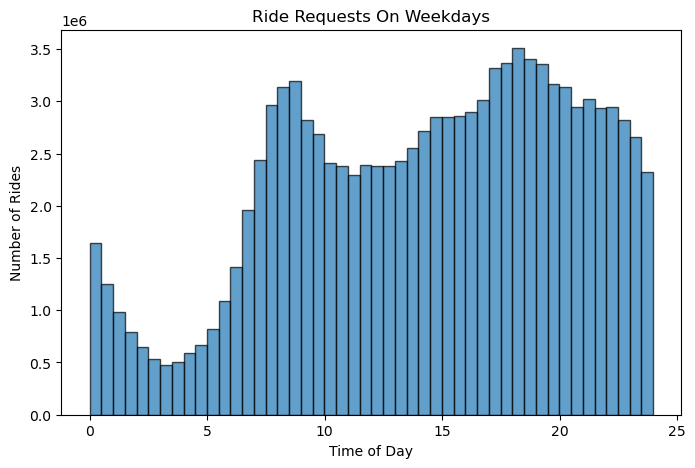

In [8]:
#Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(df_2023[df_2023['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]["request_time_of_day"], bins=48, edgecolor="black", alpha=0.7)
plt.xlabel("Time of Day")
plt.ylabel("Number of Rides")
plt.title("Ride Requests On Weekdays")
plt.show()

We notice two distinct peak times: the before work morning commute (7-10 am) and the after work commute (5-7:30).

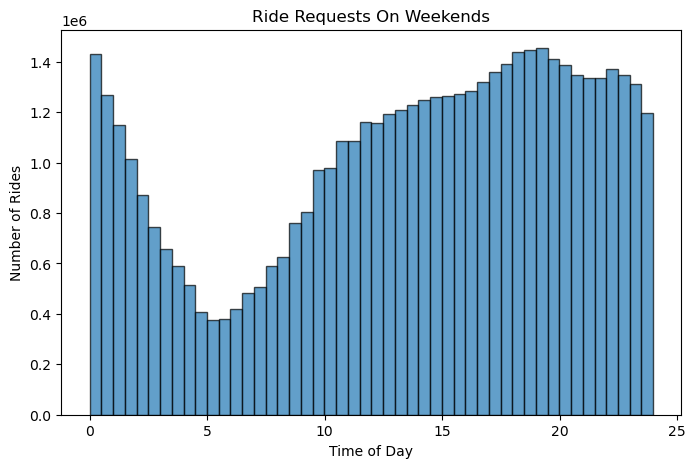

In [9]:
#Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(df_2023[df_2023['day_of_week'].isin(['Saturday', 'Sunday'])]["request_time_of_day"], bins=48, edgecolor="black", alpha=0.7)
plt.xlabel("Time of Day")
plt.ylabel("Number of Rides")
plt.title("Ride Requests On Weekends")
plt.show()

We see that there are two big spikes of rides: the rush hour to work, and when people are heading back from work for weekdays. On weekends, we see a much higher proportion of rides take place in the early morning hours and afternoon - prime entertainment hours!

We'll investigate the difference between the spectral clusterings for weekdays vs weekends below, along with other time frames! This will help us understand how New Yorkers move move about the city on different days, holidays, and even times of the day!

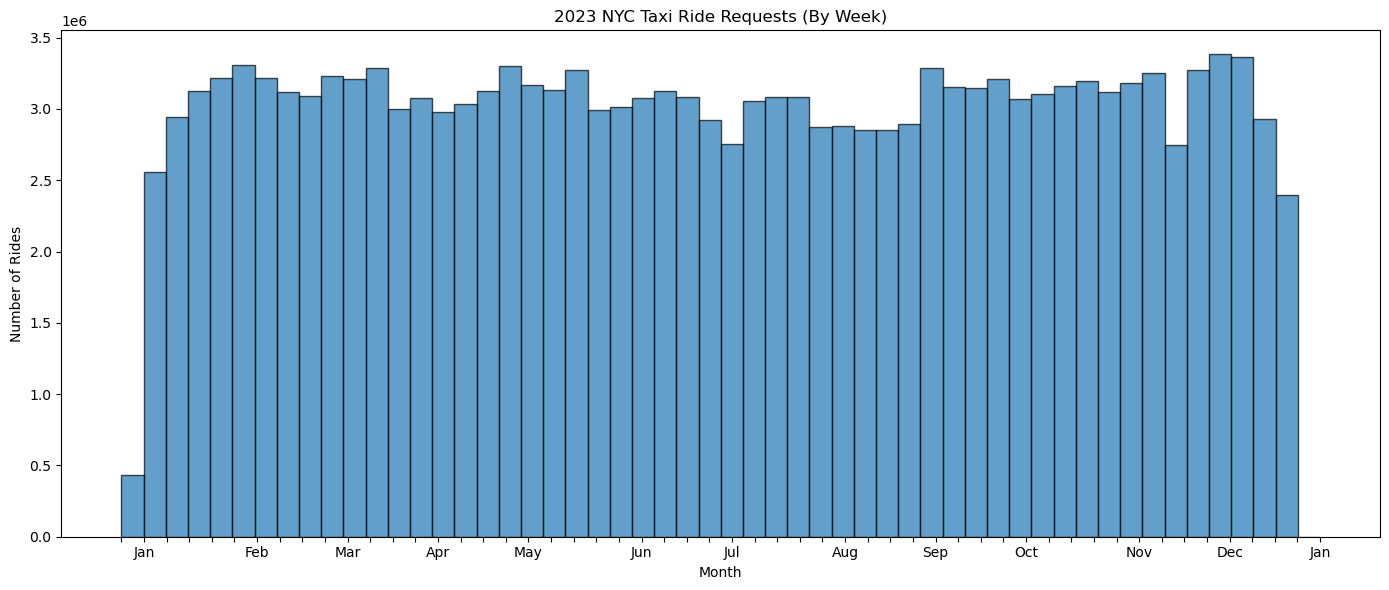

In [10]:
week_starts = df_2023['request_datetime'].dt.to_period('W').dt.start_time
weekly_counts = week_starts.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(14, 6))

ax.hist(
    range(len(weekly_counts)), 
    bins=len(weekly_counts), 
    weights=weekly_counts.values,
    edgecolor="black",
    alpha=0.7
)

ticks = range(len(weekly_counts))
labels = weekly_counts.index

custom_labels = []
for date in labels:
    if date.day <= 7:
        custom_labels.append(date.strftime('%b'))
    else:
        custom_labels.append('')

ax.set_xticks(ticks)
ax.set_xticklabels(custom_labels, rotation=0, ha='center')

plt.xlabel('Month')
plt.ylabel('Number of Rides')
plt.title('2023 NYC Taxi Ride Requests (By Week)')
plt.tight_layout()
plt.show()

# Create Functions

These below functions will be called as we create spectral clustering visualizations for NYC in different time windows

### Create adjacency matrix

In [11]:
def adjacency_matrix(df, num_locations=263): #263 taxi zones
    adj_matrix = np.zeros((num_locations, num_locations), dtype=int)
    pu_locations = df['PULocationID'].to_numpy()
    do_locations = df['DOLocationID'].to_numpy()

    pu_locations -= 1
    do_locations -= 1
    np.add.at(adj_matrix, (pu_locations, do_locations), 1)
    np.add.at(adj_matrix, (do_locations, pu_locations), 1)

    return adj_matrix

### Spectral Clustering

In [12]:
def spec_clustering(adj_mat, n_clusters):
    clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=6740)
    
    labels = clustering.fit_predict(adj_mat)
    
    #ties the cluster labels back to the taxi zones
    location_ids = np.arange(1, 264)
    cluster_df = pd.DataFrame({
    'LocationID': location_ids,
    'Cluster': labels
    })
    
    zone_clusters = pd.merge(taxi_zones, cluster_df, on='LocationID', how='inner')
    zone_clusters = zone_clusters[['LocationID', 'Zone', 'Cluster']]
    return zone_clusters

### Visualize Spectral Clustering on a map

In [13]:
def vis_clustering(zones_gdf, clusters, num_clusters, window_of_interest):
    zones_with_clusters = zones_gdf.merge(clusters, on="LocationID")
    fig, ax = plt.subplots(figsize=(10, 10))
    zones_with_clusters.plot(column='Cluster', ax=ax, legend=False, cmap='tab20', edgecolor='black', linewidth = 0.7)
    ax.set_title(f"Spectral Clustering of NYC Zones by Uber Ride Patterns\n{window_of_interest}\nNumber of clusters = {num_clusters}", fontsize=14)
    ax.axis('off')
    
    handles = []
    for cluster_value in np.unique(zones_with_clusters['Cluster']):
        color = plt.cm.tab20(cluster_value / float(np.max(zones_with_clusters['Cluster'])))
        handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=str(cluster_value))
        handles.append(handle)

    ax.legend(handles=handles, title="Cluster Group", bbox_to_anchor=(1, 0.5), loc='center left')
    plt.tight_layout()
    
    base_dir = "plots"
    subfolder = os.path.join(base_dir, window_of_interest, "Map Images")
    os.makedirs(subfolder, exist_ok=True)
    plot_filename = f"{window_of_interest}_with_{num_clusters}_clusters_map.png"
    plot_path = os.path.join(subfolder, plot_filename)
    plt.savefig(plot_path, dpi=300)
    plt.close()

    print(f"Map saved as {plot_path}")

### Visualize Spectral Clustering as a network

In [14]:
def plot_cluster_network(adj_matrix, cluster_labels, window_of_interest, num_clusters, focus_on_lcc=True):
    G = nx.Graph()
    num_nodes = adj_matrix.shape[0]

    if isinstance(cluster_labels, pd.DataFrame):
        node_names = cluster_labels.iloc[:, 1]  #Column 1 for node names
        cluster_labels = cluster_labels.iloc[:, 2]  #Column 2 for cluster labels

    cluster_labels = cluster_labels.fillna(-1).astype(int)
    
    unique_clusters = sorted(cluster_labels.unique())
    cluster_to_index = {label: idx for idx, label in enumerate(unique_clusters)}
    
    for i in range(num_nodes):
        original_cluster = cluster_labels.iloc[i]
        G.add_node(node_names.iloc[i], cluster=cluster_to_index[original_cluster])

    #add edges
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            weight = adj_matrix[i, j]
            if weight > 0:
                G.add_edge(node_names.iloc[i], node_names.iloc[j], weight=weight)

    if focus_on_lcc:
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    pos = nx.spring_layout(G, seed=6740, k=20, scale=50, iterations=100)

    clusters = nx.get_node_attributes(G, 'cluster')
    cluster_indices = np.array(list(clusters.values()))
    
    #color palette for clusters
    color_palette = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
    node_colors = [color_palette[clusters[node]] for node in G.nodes]

    # --- Plot with labels ---
    fig, ax = plt.subplots(figsize=(14, 14))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=1, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.1, ax=ax)
    
    #use the node names for labels
    node_labels = {node: node for node in G.nodes}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=5, ax=ax)  # Adjusted font size for readability
    ax.set_title(f"Spectral Clustering of NYC Taxi Zones as Network\n{window_of_interest}\nClusters = {num_clusters}", fontsize=16)
    ax.axis("off")

    #add legend for clusters
    handles = []
    for cluster_idx, cluster_name in enumerate(unique_clusters):
        handle = plt.Line2D([0], [0], marker='o', color='w', label=str(cluster_name), 
                             markerfacecolor=color_palette[cluster_idx], markersize=10)
        handles.append(handle)

    ax.legend(handles=handles, title="Cluster Group", bbox_to_anchor=(1, 0.5), loc='center left')

    #save plot with labels
    base_dir = "plots"
    subfolder = os.path.join(base_dir, window_of_interest, "Network Images")
    os.makedirs(subfolder, exist_ok=True)
    filename_labels = f"{window_of_interest}_with_{num_clusters}_clusters_network_labels.png"
    plt.savefig(os.path.join(subfolder, filename_labels), dpi=300, bbox_inches="tight")
    plt.close()

    # --- Plot without labels ---
    fig, ax = plt.subplots(figsize=(14, 14))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=1, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.1, ax=ax)
    ax.set_title(f"Spectral Clustering of NYC Taxi Zones as Network\n{window_of_interest}\nClusters = {num_clusters}", fontsize=16)
    ax.axis("off")

    #add legend for clusters
    ax.legend(handles=handles, title="Cluster Group", bbox_to_anchor=(1, 0.5), loc='center left')

    #aave plot without labels
    filename_no_labels = f"{window_of_interest}_with_{num_clusters}_clusters_network.png"
    plt.savefig(os.path.join(subfolder, filename_no_labels), dpi=300, bbox_inches="tight")
    plt.close()

In [15]:
def plot_cluster_network_small_data(adj_matrix, cluster_labels, window_of_interest, num_clusters, focus_on_lcc=True):
    G = nx.Graph()
    num_nodes = adj_matrix.shape[0]

    if isinstance(cluster_labels, pd.DataFrame):
        node_names = cluster_labels.iloc[:, 1]  #Column 1 for node names
        cluster_labels = cluster_labels.iloc[:, 2]  #Column 2 for cluster labels

    cluster_labels = cluster_labels.fillna(-1).astype(int)
    
    unique_clusters = sorted(cluster_labels.unique())
    cluster_to_index = {label: idx for idx, label in enumerate(unique_clusters)}
    
    for i in range(num_nodes):
        original_cluster = cluster_labels.iloc[i]
        G.add_node(node_names.iloc[i], cluster=cluster_to_index[original_cluster])

    #add edges
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            weight = adj_matrix[i, j]
            if weight > 0:
                G.add_edge(node_names.iloc[i], node_names.iloc[j], weight=weight)

    if focus_on_lcc:
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    #pos = nx.spring_layout(G, seed=6740, k=.5, scale=30, iterations=30) # use for post-NYE
    pos = nx.spring_layout(G, seed=6740, k=2, scale=20, iterations=30) # use for US Open, XMAS

    clusters = nx.get_node_attributes(G, 'cluster')
    cluster_indices = np.array(list(clusters.values()))
    
    #color palette for clusters
    color_palette = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
    node_colors = [color_palette[clusters[node]] for node in G.nodes]

    # --- Plot with labels ---
    fig, ax = plt.subplots(figsize=(14, 14))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=1, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.1, ax=ax)
    
    #use the node names for labels
    node_labels = {node: node for node in G.nodes}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=5, ax=ax)  # Adjusted font size for readability
    ax.set_title(f"Spectral Clustering of NYC Taxi Zones as Network\n{window_of_interest}\nClusters = {num_clusters}", fontsize=16)
    ax.axis("off")

    #add legend for clusters
    handles = []
    for cluster_idx, cluster_name in enumerate(unique_clusters):
        handle = plt.Line2D([0], [0], marker='o', color='w', label=str(cluster_name), 
                             markerfacecolor=color_palette[cluster_idx], markersize=10)
        handles.append(handle)

    ax.legend(handles=handles, title="Cluster Group", bbox_to_anchor=(1, 0.5), loc='center left')

    #save plot with labels
    base_dir = "plots"
    subfolder = os.path.join(base_dir, window_of_interest, "Network Images")
    os.makedirs(subfolder, exist_ok=True)
    filename_labels = f"{window_of_interest}_with_{num_clusters}_clusters_network_labels.png"
    plt.savefig(os.path.join(subfolder, filename_labels), dpi=300, bbox_inches="tight")
    plt.close()

    # --- Plot without labels ---
    fig, ax = plt.subplots(figsize=(14, 14))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=1, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.1, ax=ax)
    ax.set_title(f"Spectral Clustering of NYC Taxi Zones as Network\n{window_of_interest}\nClusters = {num_clusters}", fontsize=16)
    ax.axis("off")

    #add legend for clusters
    ax.legend(handles=handles, title="Cluster Group", bbox_to_anchor=(1, 0.5), loc='center left')

    #aave plot without labels
    filename_no_labels = f"{window_of_interest}_with_{num_clusters}_clusters_network.png"
    plt.savefig(os.path.join(subfolder, filename_no_labels), dpi=300, bbox_inches="tight")
    plt.close()

# Subdivide Data

### Let's make sure we our method is correct!
Period of Interest: January, 2023

In [16]:
start = pd.to_datetime("2023-01-01 00:00:00")
end = pd.to_datetime("2023-02-01 00:00:00")

jan_df = df_2023[(df_2023["request_datetime"] >= start) &
                 (df_2023["request_datetime"] < end)]

In [17]:
for num_clusters in range(3, 21):
    df_copy = jan_df.copy()
    period_of_interest = "January, 2023"
    adj_mat = adjacency_matrix(df_copy)
    clusters = spec_clustering(adj_mat, num_clusters)
    vis_clustering(zones_gdf, clusters, num_clusters, period_of_interest)
    plot_cluster_network(adj_mat, clusters, period_of_interest, num_clusters)
del jan_df
del df_copy

Map saved as plots\January, 2023\Map Images\January, 2023_with_3_clusters_map.png
Map saved as plots\January, 2023\Map Images\January, 2023_with_4_clusters_map.png
Map saved as plots\January, 2023\Map Images\January, 2023_with_5_clusters_map.png
Map saved as plots\January, 2023\Map Images\January, 2023_with_6_clusters_map.png
Map saved as plots\January, 2023\Map Images\January, 2023_with_7_clusters_map.png
Map saved as plots\January, 2023\Map Images\January, 2023_with_8_clusters_map.png
Map saved as plots\January, 2023\Map Images\January, 2023_with_9_clusters_map.png
Map saved as plots\January, 2023\Map Images\January, 2023_with_10_clusters_map.png
Map saved as plots\January, 2023\Map Images\January, 2023_with_11_clusters_map.png
Map saved as plots\January, 2023\Map Images\January, 2023_with_12_clusters_map.png
Map saved as plots\January, 2023\Map Images\January, 2023_with_13_clusters_map.png
Map saved as plots\January, 2023\Map Images\January, 2023_with_14_clusters_map.png
Map saved a

### Peak tourist season: December
Period of Interest: December, 2023

In [24]:
start = pd.to_datetime("2023-12-01 00:00:00")
end = pd.to_datetime("2023-12-31 00:00:00")

dec_df = df_2023[(df_2023["request_datetime"] >= start) &
                 (df_2023["request_datetime"] < end)]

In [26]:
for num_clusters in range(3, 21):
    df_copy = dec_df.copy()
    period_of_interest = "December, 2023"
    adj_mat = adjacency_matrix(df_copy)
    clusters = spec_clustering(adj_mat, num_clusters)
    vis_clustering(zones_gdf, clusters, num_clusters, period_of_interest)
    plot_cluster_network(adj_mat, clusters, period_of_interest, num_clusters)
del dec_df
del df_copy

Map saved as plots\December, 2023\Map Images\December, 2023_with_3_clusters_map.png
Map saved as plots\December, 2023\Map Images\December, 2023_with_4_clusters_map.png
Map saved as plots\December, 2023\Map Images\December, 2023_with_5_clusters_map.png
Map saved as plots\December, 2023\Map Images\December, 2023_with_6_clusters_map.png
Map saved as plots\December, 2023\Map Images\December, 2023_with_7_clusters_map.png
Map saved as plots\December, 2023\Map Images\December, 2023_with_8_clusters_map.png
Map saved as plots\December, 2023\Map Images\December, 2023_with_9_clusters_map.png
Map saved as plots\December, 2023\Map Images\December, 2023_with_10_clusters_map.png
Map saved as plots\December, 2023\Map Images\December, 2023_with_11_clusters_map.png
Map saved as plots\December, 2023\Map Images\December, 2023_with_12_clusters_map.png
Map saved as plots\December, 2023\Map Images\December, 2023_with_13_clusters_map.png
Map saved as plots\December, 2023\Map Images\December, 2023_with_14_clus

### Weekday Morning Commute

We look at the weekday morning commute (7 am to 10 am)

In [ ]:
start_time = pd.to_datetime("07:00:00").time()
end_time = pd.to_datetime("10:00:00").time()

morning_commute = df_2023[
    (df_2023["request_datetime"].dt.time >= start_time) & 
    (df_2023["request_datetime"].dt.time <= end_time) & 
    (df_2023['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']))
]

In [ ]:
for num_clusters in range(3, 21):
    df_copy = morning_commute.copy()
    period_of_interest = "Morning Commute, 7 AM - 10 AM on weekdays"
    adj_mat = adjacency_matrix(df_copy)
    clusters = spec_clustering(adj_mat, num_clusters)
    vis_clustering(zones_gdf, clusters, num_clusters, period_of_interest)
    plot_cluster_network(adj_mat, clusters, period_of_interest, num_clusters)
del morning_commute
del df_copy

## Post NYE (Jan 1st, Midnight - 3AM)

In [ ]:
start = pd.to_datetime("2023-01-01 00:00:00")
end = pd.to_datetime("2023-01-01 03:00:00")

NYE_df = df_2023[(df_2023["request_datetime"] >= start) &
                 (df_2023["request_datetime"] < end)]

In [ ]:
for num_clusters in range(3, 21):
    df_copy = NYE_df.copy()
    period_of_interest = "After New Year's Eve, January 1st; Midnight - 3 AM"
    adj_mat = adjacency_matrix(df_copy)
    clusters = spec_clustering(adj_mat, num_clusters)
    vis_clustering(zones_gdf, clusters, num_clusters, period_of_interest)
    plot_cluster_network_small_data(adj_mat, clusters, period_of_interest, num_clusters)
del NYE_df
del df_copy

## Evening Commute on Weekdays

In [ ]:
start_time = pd.to_datetime("17:00:00").time()
end_time = pd.to_datetime("19:00:00").time()

evening_commute = df_2023[
    (df_2023["request_datetime"].dt.time >= start_time) & 
    (df_2023["request_datetime"].dt.time <= end_time) & 
    (df_2023['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']))
]

In [ ]:
for num_clusters in range(3, 21):
    df_copy = evening_commute.copy()
    period_of_interest = "Evening Commute, 5 PM - 7 PM on weekdays"
    adj_mat = adjacency_matrix(df_copy)
    clusters = spec_clustering(adj_mat, num_clusters)
    vis_clustering(zones_gdf, clusters, num_clusters, period_of_interest)
    plot_cluster_network(adj_mat, clusters, period_of_interest, num_clusters)
del evening_commute
del df_copy

## Christmas Day

In [ ]:
start = pd.to_datetime("2023-12-25 00:00:00")
end = pd.to_datetime("2023-12-26 00:00:00")

xmas_df = df_2023[(df_2023["request_datetime"] >= start) &
                 (df_2023["request_datetime"] < end)]

In [ ]:
for num_clusters in range(3, 21):
    df_copy = xmas_df.copy()
    period_of_interest = "Christmas Day"
    adj_mat = adjacency_matrix(df_copy)
    clusters = spec_clustering(adj_mat, num_clusters)
    vis_clustering(zones_gdf, clusters, num_clusters, period_of_interest)
    plot_cluster_network_small_data(adj_mat, clusters, period_of_interest, num_clusters)
del xmas_df
del df_copy

## Weekend Nights
The hypothesis here is that the Friday and Saturday nights, as people are coming back from bars and clubs, we may see different connectivity patterns than during normal hours

In [ ]:
start_time = pd.to_datetime("00:00:00").time()
end_time = pd.to_datetime("04:00:00").time()

post_club_df = df_2023[
    (df_2023["request_datetime"].dt.time >= start_time) & 
    (df_2023["request_datetime"].dt.time <= end_time) & 
    (df_2023['day_of_week'].isin(['Saturday', 'Sunday']))
]

In [ ]:
for num_clusters in range(3, 21):
    df_copy = post_club_df.copy()
    period_of_interest = "Late nights on weekends, 12 AM - 4 AM"
    adj_mat = adjacency_matrix(df_copy)
    clusters = spec_clustering(adj_mat, num_clusters)
    vis_clustering(zones_gdf, clusters, num_clusters, period_of_interest)
    plot_cluster_network(adj_mat, clusters, period_of_interest, num_clusters)
del post_club_df
del df_copy

## Off-peak Hours
Let's see how the city is connected between 3 and 5 am on weekdays, when we see the least rides.

In [ ]:
start_time = pd.to_datetime("03:00:00").time()
end_time = pd.to_datetime("05:00:00").time()

off_peak_df = df_2023[
    (df_2023["request_datetime"].dt.time >= start_time) & 
    (df_2023["request_datetime"].dt.time <= end_time) & 
    (df_2023['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']))
]

In [ ]:
for num_clusters in range(3, 21):
    df_copy = off_peak_df.copy()
    period_of_interest = "Off-Peak Hours, 3 AM - 5 AM on Weekdays"
    adj_mat = adjacency_matrix(df_copy)
    clusters = spec_clustering(adj_mat, num_clusters)
    vis_clustering(zones_gdf, clusters, num_clusters, period_of_interest)
    plot_cluster_network(adj_mat, clusters, period_of_interest, num_clusters)
del off_peak_df
del df_copy

### US Open Tennis Tournament

In [18]:
start = pd.to_datetime("2023-08-28 00:00:00")
end = pd.to_datetime("2023-09-11 00:00:00")

us_open_df = df_2023[(df_2023["request_datetime"] >= start) &
                 (df_2023["request_datetime"] < end)]

In [19]:
for num_clusters in range(3, 21):
    df_copy = us_open_df.copy()
    period_of_interest = "US Open Days, Aug 28 - Sep 10"
    adj_mat = adjacency_matrix(df_copy)
    clusters = spec_clustering(adj_mat, num_clusters)
    vis_clustering(zones_gdf, clusters, num_clusters, period_of_interest)
    plot_cluster_network_small_data(adj_mat, clusters, period_of_interest, num_clusters)
del us_open_df
del df_copy

Map saved as plots\US Open Days, Aug 28 - Sep 10\Map Images\US Open Days, Aug 28 - Sep 10_with_3_clusters_map.png
Map saved as plots\US Open Days, Aug 28 - Sep 10\Map Images\US Open Days, Aug 28 - Sep 10_with_4_clusters_map.png
Map saved as plots\US Open Days, Aug 28 - Sep 10\Map Images\US Open Days, Aug 28 - Sep 10_with_5_clusters_map.png
Map saved as plots\US Open Days, Aug 28 - Sep 10\Map Images\US Open Days, Aug 28 - Sep 10_with_6_clusters_map.png
Map saved as plots\US Open Days, Aug 28 - Sep 10\Map Images\US Open Days, Aug 28 - Sep 10_with_7_clusters_map.png
Map saved as plots\US Open Days, Aug 28 - Sep 10\Map Images\US Open Days, Aug 28 - Sep 10_with_8_clusters_map.png
Map saved as plots\US Open Days, Aug 28 - Sep 10\Map Images\US Open Days, Aug 28 - Sep 10_with_9_clusters_map.png
Map saved as plots\US Open Days, Aug 28 - Sep 10\Map Images\US Open Days, Aug 28 - Sep 10_with_10_clusters_map.png
Map saved as plots\US Open Days, Aug 28 - Sep 10\Map Images\US Open Days, Aug 28 - Sep 

### 2 Weeks After US Open Tennis Tournament

In [27]:
start = pd.to_datetime("2023-09-11 00:00:00")
end = pd.to_datetime("2023-09-25 00:00:00")

post_us_open_df = df_2023[(df_2023["request_datetime"] >= start) &
                 (df_2023["request_datetime"] < end)]

In [28]:
for num_clusters in range(3, 21):
    df_copy = post_us_open_df.copy()
    period_of_interest = "Two weeks after US Open, Sep 11 - Sep 24"
    adj_mat = adjacency_matrix(df_copy)
    clusters = spec_clustering(adj_mat, num_clusters)
    vis_clustering(zones_gdf, clusters, num_clusters, period_of_interest)
    plot_cluster_network_small_data(adj_mat, clusters, period_of_interest, num_clusters)
del post_us_open_df
del df_copy

Map saved as plots\Two weeks after US Open, Sep 11 - Sep 24\Map Images\Two weeks after US Open, Sep 11 - Sep 24_with_3_clusters_map.png
Map saved as plots\Two weeks after US Open, Sep 11 - Sep 24\Map Images\Two weeks after US Open, Sep 11 - Sep 24_with_4_clusters_map.png
Map saved as plots\Two weeks after US Open, Sep 11 - Sep 24\Map Images\Two weeks after US Open, Sep 11 - Sep 24_with_5_clusters_map.png
Map saved as plots\Two weeks after US Open, Sep 11 - Sep 24\Map Images\Two weeks after US Open, Sep 11 - Sep 24_with_6_clusters_map.png
Map saved as plots\Two weeks after US Open, Sep 11 - Sep 24\Map Images\Two weeks after US Open, Sep 11 - Sep 24_with_7_clusters_map.png
Map saved as plots\Two weeks after US Open, Sep 11 - Sep 24\Map Images\Two weeks after US Open, Sep 11 - Sep 24_with_8_clusters_map.png
Map saved as plots\Two weeks after US Open, Sep 11 - Sep 24\Map Images\Two weeks after US Open, Sep 11 - Sep 24_with_9_clusters_map.png
Map saved as plots\Two weeks after US Open, Sep 

### All of 2023

In [ ]:
for num_clusters in range(3, 21):
    df_copy = df_2023.copy()
    period_of_interest = "All of 2023"
    adj_mat = adjacency_matrix(df_copy)
    clusters = spec_clustering(adj_mat, num_clusters)
    vis_clustering(zones_gdf, clusters, num_clusters, period_of_interest)
    plot_cluster_network(adj_mat, clusters, period_of_interest, num_clusters)
del df_copy